In [68]:
#同じ時間のアクションとしては、来客→回収の順番で処理

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

def strong_function(base,ker):
    def strong_function_t(t):
        y = base
        for i in range(len(ker)):
            mu = ker[i][0]
            sigma = ker[i][1]
            y = y + (math.exp(-(t-mu)**2/(2*sigma))) / math.sqrt(2*math.pi*sigma)
        return y
    return strong_function_t

def make_day_data(day):
    #パラメータの設定
    dt = 0.010#時間幅、単位は時間
    T = 16#時間の総量、7時～23時の16時間をイメージ
    F = 2#フロア数
    
    S = np.zeros(F).astype('int')
    S[0] = 1000
    A = np.zeros((F,F)).astype('int')
    
    f = []
    f.append(strong_function(0.2,[[0.2,0.0005],[0.6,0.0005]]))
    f.append(strong_function(0.2,[[0.4,0.0005],[0.8,0.0005]]))
    
    df = pd.DataFrame(columns=(['day','time']+['S'+str(i) for i in range(F)]))
    df_move = pd.DataFrame(columns=(['day','time','in','out','passenger']+['S'+str(i) for i in range(F)]))
    
    for t in range(int(T/dt)):
        for f_in in range(F):
            for f_out in range(F):
                if f_in!=f_out:
                    if f_in<0:
                        A[f_in,f_out] = A[f_in,f_out]+f[0](t*dt/T)*np.random.poisson(40*dt)
                    else:
                        #付け焼刃的に直したので、スマートにしたい
                        A[f_in,f_out] = min(A[f_in,f_out]+f[f_in](t*dt/T)*np.sqrt(S[f_in]-np.sum(A[f_in,:]))*np.random.poisson(20*dt), (S[f_in]-np.sum(A[f_in,:])))        
        
        for f_in in range(F):
            for f_out in range(F):
                if(f_in!=f_out):
                    e_come = np.random.poisson(20*dt)
                    if(e_come>0):
                        if A[f_in,f_out]>0:
                            df_move.loc[len(df_move)+1] = ([day,dt*t]+[f_in,f_out,A[f_in,f_out]]+[S[i] for i in range(F)])
                            S[f_out] = S[f_out]+A[f_in,f_out]
                            S[f_in] = S[f_in]-A[f_in,f_out]
                            A[f_in,f_out]=0
                        
                        
        
        df.loc[t] = ([day,dt*t]+[S[i] for i in range(F)])
    return df,df_move

def main():
    for i in range(100):
        df,df_move = make_day_data(i)
        if i==0:
            df_all = df_move
        else:
            df_all = pd.concat([df_all,df_move])
        print(i,len(df_move))
    df_all.to_csv('df_all.csv',index=False)
    print(len(df_all))
    print(df_all.head())
    
if __name__ =='__main__':
    main()

0 281
1 285
2 291
3 263
4 300
5 303
6 310
7 291
8 300
9 296
10 294
11 286
12 319
13 314
14 301
15 298
16 287
17 309
18 284
19 292
20 294
21 295
22 282
23 302
24 305
25 281
26 317
27 277
28 284
29 297
30 308
31 313
32 298
33 308
34 276
35 278
36 288
37 291
38 284
39 305
40 280
41 292
42 286
43 277
44 294
45 286
46 297
47 315
48 308
49 301
50 309
51 295
52 303
53 310
54 273
55 293
56 283
57 293
58 266
59 308
60 295
61 313
62 287
63 300
64 289
65 315
66 294
67 309
68 294
69 295
70 311
71 293
72 292
73 307
74 293
75 298
76 273
77 273
78 297
79 288
80 277
81 282
82 285
83 284
84 310
85 279
86 296
87 300
88 293
89 302
90 293
91 294
92 285
93 291
94 300
95 291
96 280
97 302
98 305
99 310
29431
   day  time   in  out  passenger      S0    S1
1  0.0  0.02  0.0  1.0        6.0  1000.0   0.0
2  0.0  0.06  0.0  1.0        6.0   994.0   6.0
3  0.0  0.08  0.0  1.0        6.0   988.0  12.0
4  0.0  0.18  0.0  1.0       12.0   982.0  18.0
5  0.0  0.33  1.0  0.0        2.0   970.0  30.0


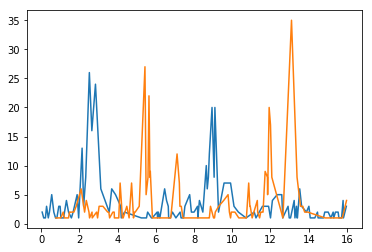

In [52]:
df_move = pd.read_csv('df_all.csv')
df_move01 = df_move[df_move['in']==0]
plt.plot(df_move01['time'],df_move01['passenger'])
df_move10 = df_move[df_move['in']==1]
plt.plot(df_move10['time'],df_move10['passenger'])
plt.show()

In [78]:
df_all = pd.read_csv('df_all.csv')
df_all = df_all[df_all['in']==1]
df_all = df_all.reset_index(drop=True)

for i in range(len(df_all)):
    if i==0 or (df_all.loc[i,'time']-df_all.loc[i-1,'time'])<=0:
        df_all.loc[i,'passenger_pt'] = df_all.loc[i,'passenger']/df_all.loc[i,'time']
        df_all.loc[i,'dtime'] = df_all.loc[i,'time']
    else:
        df_all.loc[i,'passenger_pt'] = df_all.loc[i,'passenger']/(df_all.loc[i,'time']-df_all.loc[i-1,'time'])
        df_all.loc[i,'dtime'] =(df_all.loc[i,'time']-df_all.loc[i-1,'time'])
    for j in range(10):
        if i<(j+1) or (df_all.loc[i,'time']-df_all.loc[i-j-1,'time'])<=0:
            df_all.loc[i,'previous'+str(j+1)]=-1
        else:
            df_all.loc[i,'previous'+str(j+1)] = df_all.loc[i-j-1,'passenger']
df_all.to_csv('df_all_.csv',index=False)

,day,time,in,out,passenger,S0,S1,passenger_pt,dtime,previous1,previous2,previous3,previous4,previous5,previous6,previous7,previous8,previous9,previous10
0,0.0,0.33,1.0,0.0,2.0,970.0,30.0,6.060606,0.33,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.0,0.49,1.0,0.0,2.0,930.0,70.0,12.500000,0.16,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.0,0.64,1.0,0.0,2.0,920.0,80.0,13.333333,0.15,2.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.0,0.80,1.0,0.0,1.0,910.0,90.0,6.250000,0.16,2.0,2.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.0,1.07,1.0,0.0,3.0,911.0,89.0,11.111111,0.27,1.0,2.0,2.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
